# 사전 준비
1. 데이터셋을 다운받고 원하는 구글 드라이브 원하는 경로에 업로드합니다. [dataset.zip 다운로드](https://drive.google.com/file/d/1T5vUg75vrc8wPplsn4islRbTYLew0jNk/view?usp=sharing)
2. 구글 드라이브에 마운트하여 구글 드라이브 경로에 접근 가능하도록 합니다.


In [1]:
# 구글 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


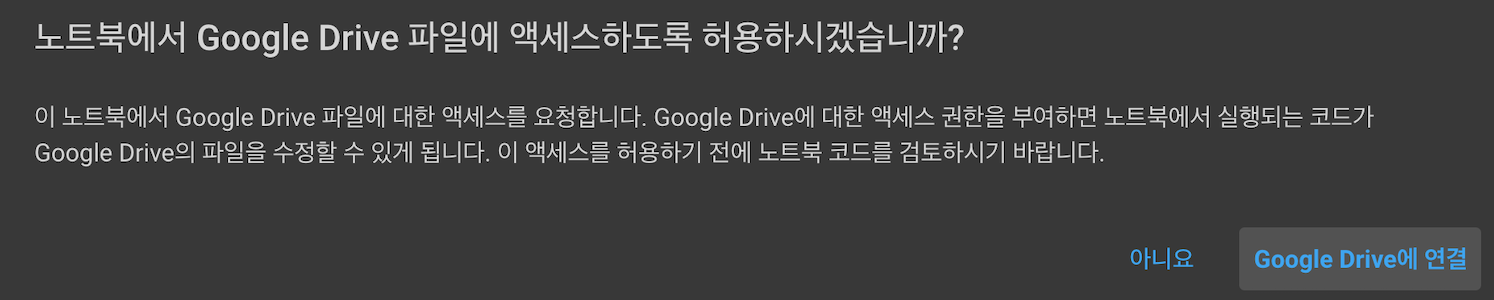

- 코드 실행 후 본인 계정으로 Google Drive에 연결을 허용합니다.
- 마운트가 완료되면 좌측 폴더 버튼을 통해 구글 드라이브에 접근할 수 있습니다.

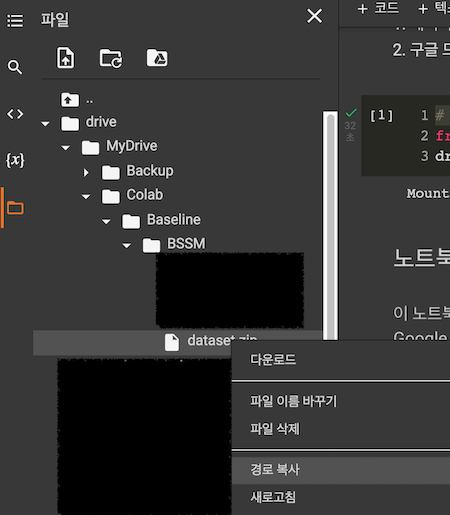

- 사진과 같이 본인이 업로드한 경로에 접근하여 dataset.zip 파일의 경로를 복사합니다. 

- unzip 명령어를 통해 dataset.zip 압축 파일을 현재 경로에 해제합니다.
`!unzip {압축 파일 경로} -d {현재 경로}`
- dataset 폴더가 생성되고 폴더 내부에 train.csv, test.csv, submit_sample.csv 파일이 생성된 것을 확인할 수 있습니다.

In [2]:
!unzip /content/drive/MyDrive/Colab/Baseline/BSSM/dataset.zip -d ./

Archive:  /content/drive/MyDrive/Colab/Baseline/BSSM/dataset.zip
   creating: ./dataset/
  inflating: ./dataset/submit_sample.csv  
  inflating: ./dataset/test.csv      
  inflating: ./dataset/train.csv     


In [3]:
# 테이블 형식의 데이터를 처리하는 pandas 라이브러리를 임포트
import pandas as pd

In [4]:
# train.csv, test.csv 파일을 DataFrame 형태로 읽어옵니다.
train_df = pd.read_csv('./dataset/train.csv')
test_df = pd.read_csv('./dataset/test.csv')
print('train shape: ', train_df.shape)
print('test shape: ', test_df.shape)

train shape:  (9375, 11)
test shape:  (4018, 10)


In [5]:
# train.csv는 총 9375개의 행과 11개의 열로 구성되어있습니다.
# 11개 열 중에서 마지막 열("body fat_%")은 예측해야 할 체지방율을 나타냅니다. 
train_df.head()

,age,gender,height_cm,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm,class,body fat_%
0,23.0,M,173.7,87.0,143.0,52.9,18.0,57.0,233.0,B,12.7
1,24.0,M,181.6,65.0,126.0,45.1,8.3,38.0,254.0,D,3.5
2,36.0,F,166.5,84.0,130.0,27.4,18.9,40.0,186.0,A,25.9
3,22.0,F,165.8,77.0,130.0,29.7,19.0,30.0,183.0,B,33.0
4,61.0,F,144.7,77.0,130.0,20.7,11.8,7.0,126.0,C,28.3


In [6]:
# test.csv에는 체지방율 정보("body fat_%")는 없으며, 체지방율 예측을 위한 feature 정보 10개만 제공됩니다.
test_df.head()

,age,gender,height_cm,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm,class
0,42.0,M,158.7,93.0,145.0,35.0,16.1,45.0,208.0,A
1,25.0,M,171.6,96.0,137.0,50.2,13.6,47.0,211.0,B
2,31.0,M,169.2,74.0,119.0,57.5,18.9,60.0,250.0,A
3,39.0,M,170.7,72.0,138.0,43.5,18.7,42.0,222.0,B
4,57.0,F,167.2,73.0,126.0,17.5,-3.4,0.0,65.0,D


In [7]:
# train_df에서 체지방율 열을 pop 하여 y_train에 저장합니다.
y_train = train_df.pop('body fat_%')

print(train_df.shape)
print(y_train.shape)

(9375, 10)
(9375,)


In [8]:
# 카테고리 데이터("gender", "class")를 One-hot 인코딩하여 데이터를 학습 가능한 형태로 재가공합니다.
train_df = pd.get_dummies(train_df, columns=['gender', 'class'])

# 평가 데이터도 마찬가지로 one-hot 인코딩 하여 추론이 가능하도록 재가공합니다.
test_df = pd.get_dummies(test_df, columns=['gender', 'class'])

print(train_df.shape)
print(test_df.shape)

(9375, 14)
(4018, 14)


In [9]:
# 기존의 gender 열은 제거되고 gender_F, gender_M이 생성되어 여성일 경우 gender_F에 1값이 기록되고, 남성일 경우 gender_M에 1이 기록되었습니다.(gender -> gender_F, gender_M)
# class 열도 동일한 방식으로 class_A,B,C,D 열이 생성되어 운동 등급에 따라 1값이 기록되었습니다.(class -> class_A, class_B, class_C, class_D)
# 학습 및 평가데이터 모두 one-hot 인코딩 되어 총 14개의 feature(age ~ class_D)를 갖게 되었습니다. 
train_df.head()

,age,height_cm,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm,gender_F,gender_M,class_A,class_B,class_C,class_D
0,23.0,173.7,87.0,143.0,52.9,18.0,57.0,233.0,0,1,0,1,0,0
1,24.0,181.6,65.0,126.0,45.1,8.3,38.0,254.0,0,1,0,0,0,1
2,36.0,166.5,84.0,130.0,27.4,18.9,40.0,186.0,1,0,1,0,0,0
3,22.0,165.8,77.0,130.0,29.7,19.0,30.0,183.0,1,0,0,1,0,0
4,61.0,144.7,77.0,130.0,20.7,11.8,7.0,126.0,1,0,0,0,1,0


In [10]:
# 카테고리 열(One-hot 인코딩 된 열)을 제외하고 age ~ broad jump_cm 열을 정규화합니다.
# 다른 정규화 방식을 찾아서 적용해보고 정규화 방식에 따라 결과가 어떻게 달라지는지 확인해봅니다.
from sklearn.preprocessing import StandardScaler 

# 학습 및 평가 데이터를 DataFrame 형태로 입력받아 정규화된 데이터로 변환하는 함수 
def scale(x_train, x_test):
    scaler = StandardScaler()

    # 학습 데이터의 age ~ broad jump_cm 열에 해당하는 값을 가져와 피팅 시킵니다.
    scaler.fit(x_train.loc[:, :'broad jump_cm'])

    # 피팅된 scaler를 기준으로 학습데이터를 정규화합니다.
    x_train.loc[:, :'broad jump_cm'] = scaler.transform(x_train.loc[:, :'broad jump_cm'])
    # 평가 데이터도 마찬가지로 학습 데이터로 피팅된 scaler를 기준으로 정규화를 진행합니다.
    x_test.loc[:, :'broad jump_cm'] = scaler.transform(x_test.loc[:, :'broad jump_cm'])

    return x_train, x_test

# 학습 데이터, 평가 데이터를 정의한 scale 함수에 전달하여 정규화된 학습 및 평가 데이터를 x_train, x_test에 저장합니다.
x_train, x_test = scale(train_df.copy(), test_df.copy())

In [11]:
# 정규화된 데이터를 확인
x_train.head()

,age,height_cm,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm,gender_F,gender_M,class_A,class_B,class_C,class_D
0,-1.017300,0.607924,0.756429,0.856821,1.494615,0.321704,1.208186,1.071876,0,1,0,1,0,0
1,-0.943974,1.544615,-1.288484,-0.300697,0.762383,-0.807248,-0.128137,1.597582,0,1,0,0,0,1
2,-0.064058,-0.245770,0.477578,-0.028340,-0.899221,0.426452,0.012529,-0.104703,1,0,1,0,0,0
3,-1.090627,-0.328768,-0.173076,-0.028340,-0.683307,0.438091,-0.690799,-0.179804,1,0,0,1,0,0
4,1.769101,-2.830565,-0.173076,-0.028340,-1.528190,-0.399894,-2.308454,-1.606719,1,0,0,0,1,0


In [12]:
x_test.head()

,age,height_cm,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm,gender_F,gender_M,class_A,class_B,class_C,class_D
0,0.375900,-1.170605,1.314133,0.993000,-0.185764,0.100569,0.364193,0.446036,0,1,1,0,0,0
1,-0.870648,0.358930,1.592985,0.448286,1.241150,-0.190398,0.504858,0.521137,0,1,0,1,0,0
2,-0.430690,0.074365,-0.451928,-0.777322,1.926444,0.426452,1.419185,1.497447,0,1,1,0,0,0
3,0.155921,0.252218,-0.637829,0.516375,0.612181,0.403175,0.153194,0.796506,0,1,0,1,0,0
4,1.475795,-0.162772,-0.544879,-0.300697,-1.828593,-2.168975,-2.800783,-3.133769,1,0,0,0,0,1


In [13]:
x_train.describe()

,age,height_cm,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm,gender_F,gender_M,class_A,class_B,class_C,class_D
count,9.375000e+03,9.375000e+03,9.375000e+03,9.375000e+03,9.375000e+03,9.375000e+03,9.375000e+03,9.375000e+03,9375.000000,9375.000000,9375.00000,9375.000000,9375.000000,9375.000000
mean,-2.471682e-16,3.060912e-15,1.185185e-16,1.105072e-16,-5.359328e-16,-3.569293e-17,1.123013e-16,2.941647e-16,0.368000,0.632000,0.25152,0.251413,0.248213,0.248853
std,1.000053e+00,1.000053e+00,1.000053e+00,1.000053e+00,1.000053e+00,1.000053e+00,1.000053e+00,1.000053e+00,0.482287,0.482287,0.43391,0.433849,0.431999,0.432372
min,-1.163953e+00,-5.166366e+00,-7.330272e+00,-8.879951e+00,-3.471422e+00,-4.100997e+00,-2.800783e+00,-4.760953e+00,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
25%,-8.706477e-01,-7.319014e-01,-7.307801e-01,-7.092328e-01,-8.898338e-01,-5.046425e-01,-6.204665e-01,-7.055096e-01,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
50%,-3.573633e-01,8.622181e-02,1.282470e-02,-2.833968e-02,8.647590e-02,1.238465e-01,8.286141e-02,9.556560e-02,0.000000,1.000000,0.00000,0.000000,0.000000,0.000000
75%,8.158583e-01,7.264922e-01,6.634789e-01,7.206428e-01,7.717702e-01,6.475874e-01,7.158566e-01,7.714728e-01,1.000000,1.000000,1.00000,1.000000,0.000000,0.000000
max,1.989080e+00,2.991152e+00,7.188611e+00,4.806002e+00,3.146831e+00,2.301714e+01,2.685175e+00,2.824228e+00,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000


In [14]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# 학습 데이터를 입력받아 체지방율(body fat_%)를 학습할 수 있는 간단한 모델을 구성합니다.
def build_model():
    # 입력 feature 개수를 첫번째 layer에 지정하고 마지막에는 1개(체지방율)을 출력할 수 있도록 모델 layer를 자유롭게 구성해봅니다. 
    model = keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=[len(x_train.columns)]),
        # ...
        layers.Dense(1)
    ])

    model.compile(
        loss='mse',
        optimizer='SGD', # 다른 optimizer를 찾아서 적용해봅니다.
        metrics=['mae', 'mse']
        )

    return model

In [15]:
# 빌드된 모델 구조를 확인합니다.
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                960       
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,025
Trainable params: 1,025
Non-trainable params: 0
_________________________________________________________________


In [16]:
# # Keras callback 함수를 이용해 val_mae(validation MAE) 에러율을 모니터링하여 15회 이상 검증셋의 MAE 스코어가 개선되지 않을 경우 중단하여 오버피팅을 방지합니다.
# earlystop_callback = keras.callbacks.EarlyStopping(monitor='val_mae', mode='min', patience=15)

# val_mae(validation MAE) 에러율을 모니터링하여 최소가 되는 단계의 모델 가중치를 저장하는 콜백함수 
save_callback = keras.callbacks.ModelCheckpoint(
    'best.h5', # 저장할 가중치 파일명
    monitor='val_mae',
    mode='min',
    save_weights_only=True, # 모델 가중치만 저장
    save_best_only=True # val_mae 에러율이 최소(min)가되는 가중치만 저장
)

# 학습을 시작하고 학습 기록을 history에 저장
history = model.fit(
    x_train, # 학습 feature 데이터(age ~ class_D)
    y_train, # 학습 target 데이터(body fat_%)
    epochs=100, # 학습 반복횟수를 100회로 설정
    validation_split=0.2, # 학습 데이터(x_train, y_train) 에서 검증셋을 20%로 다시 분할
    verbose=1, # 학습 진행 정보를 표출
    callbacks=[save_callback], # 사전에 정의한 callback을 적용
)

Epoch 1/100
235/235 [==============================] - 1s 2ms/step - loss: 33.6708 - mae: 4.3252 - mse: 33.6708 - val_loss: 24.4937 - val_mae: 3.9257 - val_mse: 24.4937
Epoch 2/100
235/235 [==============================] - 0s 2ms/step - loss: 26.0732 - mae: 3.9890 - mse: 26.0732 - val_loss: 24.1659 - val_mae: 3.9156 - val_mse: 24.1659
Epoch 3/100
235/235 [==============================] - 0s 2ms/step - loss: 25.5509 - mae: 3.9442 - mse: 25.5509 - val_loss: 32.8971 - val_mae: 4.5196 - val_mse: 32.8971
Epoch 4/100
235/235 [==============================] - 0s 2ms/step - loss: 25.1876 - mae: 3.9277 - mse: 25.1876 - val_loss: 37.7329 - val_mae: 4.9278 - val_mse: 37.7329
Epoch 5/100
235/235 [==============================] - 0s 2ms/step - loss: 25.6926 - mae: 3.9620 - mse: 25.6926 - val_loss: 29.4521 - val_mae: 4.3209 - val_mse: 29.4521
Epoch 6/100
235/235 [==============================] - 0s 2ms/step - loss: 25.0257 - mae: 3.8899 - mse: 25.0257 - val_loss: 27.6993 - val_mae: 4.2015 - val

In [17]:
# 학습 정보가 기록된 history 테이블을 확인
hist = pd.DataFrame(history.history)
print(hist.shape)
hist.head()

(100, 6)


,loss,mae,mse,val_loss,val_mae,val_mse
0,33.670807,4.325179,33.670807,24.493727,3.925656,24.493727
1,26.073193,3.989003,26.073193,24.165939,3.915597,24.165939
2,25.550858,3.944248,25.550858,32.897148,4.519649,32.897148
3,25.187593,3.927707,25.187593,37.732891,4.927824,37.732891
4,25.692574,3.962007,25.692574,29.452141,4.320878,29.452141


<Figure size 576x864 with 0 Axes>

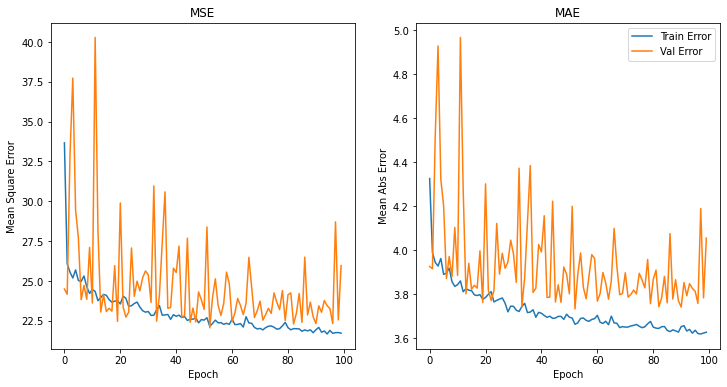

In [18]:
# 학습과 검증 셋의 MSE loss와 MAE를 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(8,12))
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6))

# MSE
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Mean Square Error')
ax1.plot(hist.index, hist['mse'], label='Train Error')
ax1.plot(hist.index, hist['val_mse'], label = 'Val Error')
ax1.set_title('MSE')

# MAE
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Mean Abs Error')
ax2.plot(hist.index, hist['mae'], label='Train Error')
ax2.plot(hist.index, hist['val_mae'], label = 'Val Error')
ax2.set_title('MAE')

plt.legend()
plt.show()


# 평가 데이터 예측 및 제출 파일 생성

In [19]:
# 모델을 다시 빌드 한 후, 사전에 학습 완료된 가중치 파일을 불러옵니다.
model = build_model()
model.load_weights('best.h5')

# 평가 데이터(x_test)를 추론하고 제출 파일형식에 맞게 csv 파일로 저장합니다.
preds = model.predict(x_test)

# 샘플 제출파일을 읽어와 4018개의 예측값을 기록하고 저장합니다.
submit = pd.read_csv('./dataset/submit_sample.csv')
submit['predict'] = preds
submit.to_csv('./my_submit.csv', index=False)

submit.head()

,predict
0,20.116032
1,21.457529
2,15.289476
3,19.277060
4,37.468609
